In [2]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
from plot_tools import simpleaxis, plot_splicing_histogram
import re
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


### Make directory to save results:

In [2]:
resultsdir = '../results/N2_Splice_Site_Analysis/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N2_Splice_Site_Analysis/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load the Data

In [3]:
data = sio.loadmat('../data/Reads.mat')

# A5SS
A5SS_data = data['A5SS']
A5SS_data = np.array(A5SS_data.todense())
# Get minigenes with reads
A5SS_nn = find(A5SS_data.sum(axis=1))
A5SS_data = A5SS_data[A5SS_nn]
A5SS_data = A5SS_data/A5SS_data.sum(axis=1)[:,newaxis]
A5SS_seqs = pd.read_csv('../data/A5SS_Seqs.csv',index_col=0).Seq[A5SS_nn]

# A3SS
A3SS_data = data['A3SS']
# Only look at SA_1 usage:
A3SS_data = np.array(A3SS_data[:,235].todense()).reshape(-1)/np.array(A3SS_data.sum(axis=1),dtype=np.float64).reshape(-1)
# Get minigenes with reads
A3SS_nn = find(pd.notnull(A3SS_data))
A3SS_data = A3SS_data[A3SS_nn]
A3SS_seqs = pd.read_csv('../data/A3SS_Seqs.csv',index_col=0).Seq[A3SS_nn]


### Make a web logo for splice donors in the A5SS library

Get the overall base frequence in the randomized regions. Unforunately, due to dna synthesis biases, it is not 25/25/25/25.

In [4]:
base_freq_all = {}
for b in dnatools.bases:
    base_freq_all[b] = pd.Series(A5SS_seqs).str.slice(7,32).str.count(b).sum() + pd.Series(A5SS_seqs).str.slice(50,75).str.count(b).sum()
base_freq_all = pd.Series(base_freq_all)

Get the base frequencies at each position (-3 to +6) at splice donors used over 10% of the time:

In [5]:
sd_base_freqs = {}
for b in range(9):
    sd_base_freqs[b] = pd.Series(A5SS_seqs[find(A5SS_data[:,11]>0.1)]).groupby(pd.Series(A5SS_seqs[find(A5SS_data[:,11]>0.1)]).str.slice(7+b,7+1+b)).size()
    for i in range(12,32-6)+range(54,75-6):
        sd_base_freqs[b] += pd.Series(A5SS_seqs[find(A5SS_data[:,i]>0.1)]).groupby(pd.Series(A5SS_seqs[find(A5SS_data[:,i]>0.1)]).str.slice(i-4+b,i-3+b)).size()
    print b,
sd_base_freqs = pd.DataFrame(sd_base_freqs)

0 1 2 3 4 5 6 7 8


Get the relative base frequencies of splice donors to all randomized sequences:

In [6]:
sd_to_random_ratio = (sd_base_freqs.fillna(0).T/base_freq_all).T

In [7]:
sd_to_random_ratio

,0,1,2,3,4,5,6,7,8
A,0.002781,0.004021,0.000654,0.000000,0.000000,0.004543,0.003677,0.001045,0.001758
C,0.002466,0.001243,0.000399,0.000000,0.000356,0.000294,0.001578,0.000662,0.001878
G,0.001603,0.001050,0.005541,0.006784,0.000000,0.001297,0.001149,0.004742,0.001654
T,0.001433,0.001082,0.000590,0.000000,0.013505,0.000437,0.001296,0.001032,0.004351


Normalize each position (column) so it sums to one:

In [8]:
normalized_base_ratio = (sd_to_random_ratio/sd_to_random_ratio.T.sum(axis=1))

In [9]:
normalized_base_ratio

,0,1,2,3,4,5,6,7,8
A,0.335781,0.543710,0.091072,0,0.00000,0.691311,0.477538,0.139713,0.182304
C,0.297667,0.168120,0.055565,0,0.02566,0.044786,0.204952,0.088456,0.194850
G,0.193551,0.141928,0.771289,1,0.00000,0.197382,0.149174,0.633856,0.171577
T,0.173000,0.146241,0.082074,0,0.97434,0.066521,0.168336,0.137974,0.451270


Now there might be a better way to do this, but I'm simply going to sample sequnces from the normalized_base_ratio computed above and submit those sequences to the web logo program.

In [10]:
base_prob_dict = normalized_base_ratio.to_dict()
sampled_bases = {}
for pos in range(9):
    sampled_bases[pos] = []
    for b in 'ACGT':
        sampled_bases[pos] += [b]*int(round(base_prob_dict[pos][b]*1000000))
    sampled_bases[pos] = np.array(sampled_bases[pos])
def make_sd():
    sd = ''
    for i in range(9):
        sd += np.random.choice(sampled_bases[i])
    return sd

In [11]:
f = open(resultsdir+'Generated_SD.txt','w')
for i in range(10000):
    f.write(make_sd()+'\n')
f.close()

I went to the weblogo website (http://weblogo.berkeley.edu/logo.cgi) and uploaded the file from above. I checked the frequency plot setting. I then downloaded and saved the file to the location below. In the actual paper figure, I drew a line at the exon-intron boundary (G|GT):

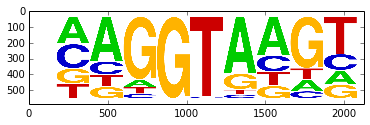

In [12]:
weblogo=matplotlib.image.imread(figdir+'Library_SD_Normalized_Frequencies.png')
imshow(weblogo)

### Make a web logo for splice acceptors in the A3SS library

The analysis here is the same as for the A5SS library, so I haven't annotated all the steps.

In [13]:
#Get each randomized region
r1 = pd.Series(A3SS_seqs).str.slice(0,25)
r2 = pd.Series(A3SS_seqs).str.slice(-25)
Y = data['A3SS'][A3SS_nn]

In [14]:
base_freq_all = {}
for b in dnatools.bases:
    base_freq_all[b] = r1.str.count(b).sum() + r2.str.count(b).sum()
base_freq_all = pd.Series(base_freq_all)

In [15]:
#Find all new SA in the two randomized regions . Then calculate the frequency of each base at each position
sa_base_freqs = {}
for p in range(15,26):
    inds = find(np.array(Y[:,189+24+25+p].todense())>0)
    for b in range(0,min(p+5,25)):
        try:
            sa_base_freqs[b-p] = sa_base_freqs[b-p].add(r2[inds].groupby(r2[inds].str.slice(b,b+1)).size(),fill_value=0)
        except:
            sa_base_freqs[b-p] = r2[inds].groupby(r2[inds].str.slice(b,b+1)).size()
for p in range(15,26):
    inds = find(np.array(Y[:,189+p].todense())>0)
    for b in range(0,min(p+5,25)):
        try:
            sa_base_freqs[b-p] = sa_base_freqs[b-p].add(r2[inds].groupby(r1[inds].str.slice(b,b+1)).size(),fill_value=0)
        except:
            sa_base_freqs[b-p] = r2[inds].groupby(r1[inds].str.slice(b,b+1)).size()
sa_base_freqs = pd.DataFrame(sa_base_freqs)

In [16]:
sa_to_random_ratio = (sa_base_freqs.fillna(0).T/base_freq_all).T
normalized_base_ratio = (sa_to_random_ratio/sa_to_random_ratio.T.sum(axis=1))

In [17]:
base_prob_dict = normalized_base_ratio.to_dict()
sampled_bases = {}
for pos in range(-25,5):
    sampled_bases[pos] = []
    for b in 'ACGT':
        sampled_bases[pos] += [b]*int(round(base_prob_dict[pos][b]*1000000))
    sampled_bases[pos] = np.array(sampled_bases[pos])
def make_sa():
    sa = ''
    for i in range(-25,5):
        sa += np.random.choice(sampled_bases[i])
    return sa

In [18]:
f = open(resultsdir+'Generated_SA.txt','w')
for i in range(10000):
    f.write(make_sa()+'\n')
f.close()

I went to the weblogo website (http://weblogo.berkeley.edu/logo.cgi) and uploaded the SA file from above. I checked the frequency plot setting. For the figure in the paper, I added a line between the intron-exon boundary (AG|G).

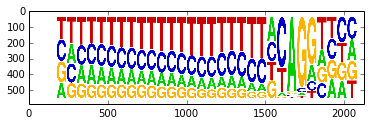

In [19]:
weblogo=matplotlib.image.imread(figdir+'Library_SA_Normalized_Frequencies.png')
imshow(weblogo)

### Analyze the location of new splice sites in the randomized regions of the A5SS library

For each new splice donor position in a randomized region, we want to calculate the mean usage. We exclude positions within 3nt of the random/fixed sequence boundaries. Here is the resulting plot:

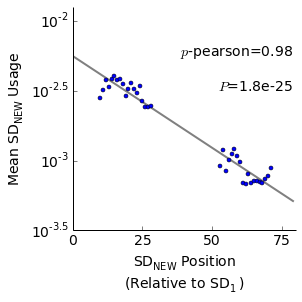

In [20]:
  
fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=fsize)
simpleaxis(ax)
reads = log10(A5SS_data.mean(axis=0))
reads[0:10]=nan
reads[29:53]=nan
reads[72:] = nan
axis([0,80,-3.5,-1.9])
ax.set_yticks(arange(-3.5,-1.99,0.5))
ax.set_yticklabels(['$10^{-3.5}$','$10^{-3}$','$10^{-2.5}$','$10^{-2}$'],ha='right')
ax.set_xticks(arange(0,100,25))
y = (np.concatenate((reads[10:29],reads[53:72])))
A = np.vstack([np.array(range(10,29)+range(53,72)), np.ones(38)]).T
m,c = np.linalg.lstsq(A,y)[0]
pred = arange(80)*m+c
plot(arange(80),pred,'gray',linewidth=2)
plot(reads,'o',markersize=4,color='b')

ax.set_ylabel('Mean $SD_{NEW}$ Usage',fontsize=fsize)
ax.set_xlabel('$SD_{NEW}$ Position\n(Relative to $SD_1$)',fontsize=fsize)

p,r = scipy.stats.pearsonr(np.concatenate((reads[10:29],reads[53:72])),np.concatenate((pred[10:29],pred[53:72])))
ax.text(79,-2.25,'$\it{p}$-pearson=%.2f' %p,ha='right',fontsize=fsize)
ax.text(79,-2.5,'$\it{P}$=%.1e' %r,ha='right',fontsize=fsize)

if SAVEFIGS:
    filename = 'Splice_Counts_vs_Distance'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=200)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=200)

Now we want to see if the slope within each randomized region is statistically significant. This is checked in the (hacky) code below.

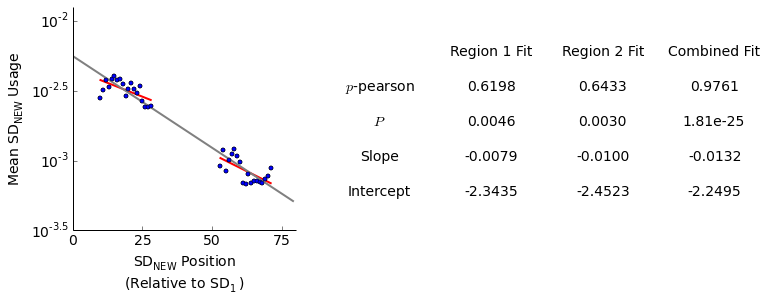

In [21]:
  
fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=fsize)
simpleaxis(ax)

tb_start_x = 110
tb_start_y = -3.25

start = 10
end = 29
reads = log10(A5SS_data.mean(axis=0))
reads[0:start]=nan
reads[end:]=nan
axis([0,80,-3.5,-1.9])
ax.set_yticks(arange(-3.5,-1.99,0.5))
ax.set_yticklabels(['$10^{-3.5}$','$10^{-3}$','$10^{-2.5}$','$10^{-2}$'],ha='right')
ax.set_xticks(arange(0,100,25))
y = reads[start:end]
A = np.vstack([range(start,end), np.ones(19)]).T
m,c = np.linalg.lstsq(A,y)[0]
pred = arange(start,end)*m+c
plot(arange(start,end),pred,'red',linewidth=2)
plot(reads,'o',markersize=4,color='b')
r,p = scipy.stats.pearsonr(reads[start:end],pred)
ax.text(tb_start_x,tb_start_y,'Intercept' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x,tb_start_y+0.25,'Slope' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x,tb_start_y+0.5,'$\it{P}$' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x,tb_start_y+0.75,'$\it{p}$-pearson' ,ha='center',fontsize=fsize)
ax.text(tb_start_x+40,tb_start_y+1,'Region 1 Fit',ha='center',fontsize=fsize)
ax.text(tb_start_x+40,tb_start_y,'%0.4f' %c,ha='center',fontsize=fsize)
ax.text(tb_start_x+40,tb_start_y+0.25,'%0.4f' %m,ha='center',fontsize=fsize)
ax.text(tb_start_x+40,tb_start_y+0.75,'%0.4f' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x+40,tb_start_y+0.5,'%0.4f' %p,ha='center',fontsize=fsize)

start = 53
end = 72
reads = log10(A5SS_data.mean(axis=0))
reads[0:start]=nan
reads[end:]=nan
axis([0,80,-3.5,-1.9])
ax.set_yticks(arange(-3.5,-1.99,0.5))
ax.set_yticklabels(['$10^{-3.5}$','$10^{-3}$','$10^{-2.5}$','$10^{-2}$'],ha='right')
ax.set_xticks(arange(0,100,25))
y = reads[start:end]
A = np.vstack([range(start,end), np.ones(19)]).T
m,c = np.linalg.lstsq(A,y)[0]
pred = arange(start,end)*m+c
plot(arange(start,end),pred,'red',linewidth=2)
plot(reads,'o',markersize=4,color='b')
r,p = scipy.stats.pearsonr(reads[start:end],pred)
ax.text(tb_start_x+80,tb_start_y+1,'Region 2 Fit',ha='center',fontsize=fsize)
ax.text(tb_start_x+80,tb_start_y,'%0.4f' %c,ha='center',fontsize=fsize)
ax.text(tb_start_x+80,tb_start_y+0.25,'%0.4f' %m,ha='center',fontsize=fsize)
ax.text(tb_start_x+80,tb_start_y+0.75,'%0.4f' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x+80,tb_start_y+0.5,'%0.4f' %p,ha='center',fontsize=fsize)

reads = log10(A5SS_data.mean(axis=0))
reads[0:10]=nan
reads[29:53]=nan
reads[72:] = nan
axis([0,80,-3.5,-1.9])
ax.set_yticks(arange(-3.5,-1.99,0.5))
ax.set_yticklabels(['$10^{-3.5}$','$10^{-3}$','$10^{-2.5}$','$10^{-2}$'],ha='right')
ax.set_xticks(arange(0,100,25))
y = (np.concatenate((reads[10:29],reads[53:72])))
A = np.vstack([np.array(range(10,29)+range(53,72)), np.ones(38)]).T
m,c = np.linalg.lstsq(A,y)[0]
pred = arange(80)*m+c
plot(arange(80),pred,'gray',linewidth=2)
plot(reads,'o',markersize=4,color='b')
r,p = scipy.stats.pearsonr(np.concatenate((reads[10:29],reads[53:72])),
                           np.concatenate((pred[10:29],pred[53:72])))

ax.text(tb_start_x+120,tb_start_y+1,'Combined Fit',ha='center',fontsize=fsize)
ax.text(tb_start_x+120,tb_start_y,'%0.4f' %c,ha='center',fontsize=fsize)
ax.text(tb_start_x+120,tb_start_y+0.25,'%0.4f' %m,ha='center',fontsize=fsize)
ax.text(tb_start_x+120,tb_start_y+0.75,'%0.4f' %r,ha='center',fontsize=fsize)
ax.text(tb_start_x+120,tb_start_y+0.5,'%1.2e' %p,ha='center',fontsize=fsize)

ax.set_ylabel('Mean $SD_{NEW}$ Usage',fontsize=fsize)
ax.set_xlabel('$SD_{NEW}$ Position\n(Relative to $SD_1$)',fontsize=fsize)

if SAVEFIGS:
    filename = 'Splice_Counts_vs_Distance_Each_Region'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=200)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=200)


Now we'll calculate the total number of reads at new splice donors in each randomized regions (not including positions within 3nt of the random/fixed sequence edges):

In [22]:
SD_new_reads_R1 = np.array(data['A5SS'].sum(axis=0)).flatten()[10:29].sum()
SD_new_reads_R2 = np.array(data['A5SS'].sum(axis=0)).flatten()[53:72].sum()
print SD_new_reads_R1,SD_new_reads_R2,SD_new_reads_R1/SD_new_reads_R2

849661.0 208395.0 4.07716595888


### Branch Point Analysis

This is the consensus branch point:

In [23]:
branch_point_consensus = re.compile('[CT]T[AG]A[CT]')

#### Count the number of consensus branch points at every position

In [24]:
branch_points_by_position = {}
for i in range(21):
    branch_points_by_position[i] = r1.str.slice(0+i,5+i).str.contains(branch_point_consensus).sum()
branch_points_by_position

{0: 12001,
 1: 10577,
 2: 12256,
 3: 11765,
 4: 11265,
 5: 11394,
 6: 11331,
 7: 11090,
 8: 11174,
 9: 11261,
 10: 11333,
 11: 11330,
 12: 11238,
 13: 11370,
 14: 11084,
 15: 11144,
 16: 11219,
 17: 11510,
 18: 11614,
 19: 11323,
 20: 10378}

Now let's check the mean usage of SA1 depending on the location (or lack) of a consensus branch point. We'll first define a function to find the position of a consensus branch point:

In [25]:
def regex_pos(reg,cur_str):
    # Get the most 3' location of the branch point
    # Return -1 if not found
    pos = -1
    for m in reg.finditer(cur_str):
        pos = m.start()
    return pos

In [26]:
# Group SA_0 by BP position and get means, num introns
grouped = pd.Series(A3SS_data).groupby(r1.apply(lambda x:regex_pos(branch_point_consensus,x)).values)
bp_pos_data = grouped.aggregate({'Mean':mean,'Size':lambda x:pd.notnull(x).sum()})

Now let's plot the results:

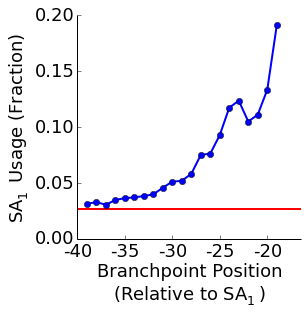

In [27]:
fsize=18

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot([-1,22.5],[bp_pos_data.Mean[-1]]*2,linewidth=2,color='r',label='No Consensus BP')
bp_pos_data.Mean[1:].plot(ax=ax,marker='o',linewidth=2,label='Consensus BP')
axis([0,22.5,0,0.2])
ax.set_xticks(range(-1,22,5));
ax.set_xticklabels(range(-21-18-1,-18,5));
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Branchpoint Position\n(Relative to $SA_1$)',fontsize=fsize)
ax.set_ylabel('$SA_1$ Usage (Fraction)',fontsize=fsize)
#leg = legend(['No BP'],numpoints=1,bbox_to_anchor=(0.8,1),fontsize=fsize)
#leg.get_frame().set_alpha(0)
#ax.text(1,0.01,'No Consenseus BP',fontsize=fsize)
ax.grid('off')
simpleaxis(ax)

if SAVEFIGS:
    filename = 'Branch_point_position'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=200)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=200)

### Check whether distance dependence on BP is due to AG exclusion zone

One possible explanation for the distance dependence is the insertion of AG dinucleotides. AGs tend to be highly depleted between the branch point and the actual splice acceptor. People have speculated that the first AG after the branch point will be spliced. So let's check if that explains the distance dependence:

In [28]:
def regex_pos_ag(reg,cur_str):
    # Get the most 3' location of the branch point
    # Return -1 if not found
    pos = -1
    for m in reg.finditer(cur_str):
        pos = m.start()
    AG_found = cur_str[pos:].find('AG')>=0
    return AG_found

In [29]:
AG_inserted = r1.apply(lambda x:regex_pos_ag(branch_point_consensus,x)).values
grouped = pd.Series(A3SS_data[AG_inserted]).groupby(r1[AG_inserted].apply(lambda x:regex_pos(branch_point_consensus,x)).values)
bp_pos_data_AG = grouped.aggregate({'Mean':mean,'Size':lambda x:pd.notnull(x).sum()})
grouped = pd.Series(A3SS_data[~AG_inserted]).groupby(r1[~AG_inserted].apply(lambda x:regex_pos(branch_point_consensus,x)).values)
bp_pos_data_noAG = grouped.aggregate({'Mean':mean,'Size':lambda x:pd.notnull(x).sum()})

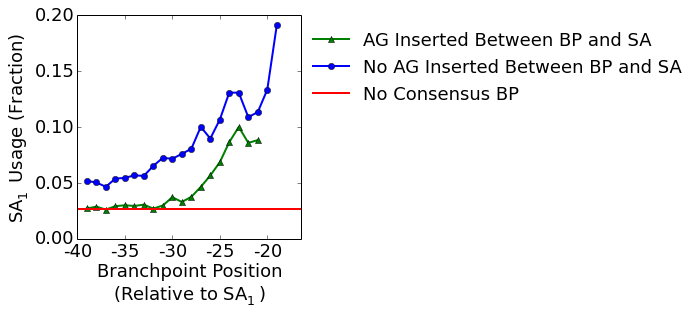

In [30]:
fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
bp_pos_data_AG.Mean.plot(ax=ax,marker='^',linewidth=2,label='AG Inserted Between BP and SA',color='g')
bp_pos_data_noAG.Mean[1:].plot(ax=ax,marker='o',linewidth=2,label='No AG Inserted Between BP and SA',color='b')
ax.plot([-1,22.5],[bp_pos_data.Mean[-1]]*2,linewidth=2,color='r',label='No Consensus BP')
axis([0,22.5,0,0.2])
ax.set_xticks(range(-1,22,5));
ax.set_xticklabels(range(-21-18-1,-18,5));
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Branchpoint Position\n(Relative to $SA_1$)',fontsize=fsize)
ax.set_ylabel('$SA_1$ Usage (Fraction)',fontsize=fsize)
leg = legend(numpoints=1,bbox_to_anchor=(2.78,1),fontsize=fsize)
leg.get_frame().set_alpha(0)
ax.grid('off')
if SAVEFIGS:
    filename = 'Branch_point_position_AG_exclusion'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=200)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=200)